<a href="https://colab.research.google.com/github/manikanta5315/Bayes_Assignments/blob/main/health_care_RAG_FAQ_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Healthcare RAG Chatbot: AI-Powered Medical Assistant
A Retrieval-Augmented Generative (RAG) chatbot designed to provide accurate, context-aware healthcare answers using hybrid retrieval and LLM-based response generation.

# Key Features
Hybrid Retrieval: Combines BM25 (sparse) and FAISS (dense) retrieval with contextual compression.
Generative Responses: Utilizes transformer models (e.g., HuggingFace, ChatGroq) via LangChain.
Knowledge Base Management: Processes medical Q&A datasets with TF-IDF for enhanced query handling.
Evaluation Metrics: Evaluates performance with Cosine Similarity, ROUGE, and BLEU.
Memory Integration: Retains context using ConversationBufferMemory.
# Technologies Used
Retrieval: BM25, FAISS, LangChain.
ML Tools: Scikit-learn, Pandas, NumPy.
Language Models: llama3-8b-8192.
# Use Cases
Patient support chatbots.
Medical Q&A systems.
Contextual search in healthcare datasets.

In [1]:
!pip install langchain langchain-community langchain-groq  langchain_huggingface sentence-transformers faiss-cpu gradio pandas scikit-learn nltk rouge rank_bm25 fuzzywuzzy python-Levenshtein -q

In [19]:
import os
import random
import gradio as gr
import pandas as pd
import nltk
from langchain import PromptTemplate
from langchain_groq import ChatGroq
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chains import ConversationChain, RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain.retrievers import BM25Retriever
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers import MultiQueryRetriever
from langchain.retrievers.ensemble import EnsembleRetriever
from langchain.schema import Document

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os
from google.colab import userdata
groq_api_key = userdata.get('groqAPI')
os.environ['GROQ_API_KEY']= groq_api_key

In [34]:
class HealthcareRAGChatbot:
    def __init__(self, knowledge_base_path, groq_api_key):
        """
        Initialize the Healthcare RAG Chatbot

        :param knowledge_base_path: Path to the CSV knowledge base
        :param groq_api_key: API key for Groq
        """
        # Setup Environment and API Key
        os.environ["GROQ_API_KEY"] = groq_api_key

        # Load Knowledge Base
        self.knowledge_base = pd.read_csv(knowledge_base_path, usecols=['question', 'answer'], low_memory=False, nrows=200)

        # TF-IDF Vectorization
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=10000, min_df=2, max_df=0.85)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.knowledge_base['question'])

        # Initialize components in the correct order
        self.setup_embeddings()
        self.setup_llm()
        self.setup_guardrails()
        self.setup_conversational_elements()
        self.prepare_documents_for_retrieval()
        self.setup_vector_database()
        self.setup_retrievers()
        self.setup_retrieval_qa_chain()
        self.setup_memory()

        self.last_query = None

    def setup_embeddings(self):
        """Initialize embeddings"""
        self.embeddings = HuggingFaceEmbeddings(
            model_name="all-MiniLM-L6-v2",
            model_kwargs={'device': 'cpu'}
        )

    def setup_llm(self):
        """Initialize the LLM"""
        try:
            self.llm = ChatGroq(
                model_name="llama3-8b-8192",  #
                temperature=0,
                max_tokens=500,
            )
        except Exception as e:
            print(f"Error initializing Groq: {str(e)}")
            raise

    def setup_guardrails(self):
        """Configure safety and ethical guardrails"""
        self.sensitive_topics = [
            'suicide', 'self-harm', 'sexual abuse',
            'domestic violence', 'emergency medical conditions'
        ]

        self.medical_disclaimer = (
            "would you like to continue?"
        )

    def setup_conversational_elements(self):
        """Setup greeting patterns and responses"""
        self.greeting_patterns = [
            'hi', 'hello', 'hey', 'good morning', 'good afternoon',
            'good evening', 'how are you', 'what\'s up', 'greetings', 'howdy'
        ]

        self.greeting_responses = [
            "Hello! I'm a healthcare assistant. How can I help you today?",
            "Hi there! I'm here to assist you with health-related questions.",
            "Greetings! I'm ready to provide helpful health information.",
            "Good day! What health concerns can I help you with today?"
        ]

    def prepare_documents_for_retrieval(self):
        """Prepare documents for vector store and retrieval"""
        self.documents = [
            Document(
                page_content=f"Question: {row['question']} Answer: {row['answer']}",
                metadata={
                    'question': row['question'],
                    'answer': row['answer']
                }
            )
            for _, row in self.knowledge_base.iterrows()
        ]

    def setup_vector_database(self):
        """Setup FAISS vector database"""
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=300,
            chunk_overlap=75
        )

        self.vectorstore = FAISS.from_documents(
            self.documents,
            self.embeddings
        )

    def setup_retrievers(self):

        # BM25 Retriever
        self.bm25_retriever = BM25Retriever.from_texts(
            [doc.page_content for doc in self.documents]
        )
        self.bm25_retriever.k = 5  # Increased k for better coverage

        # Vector Retriever from FAISS
        self.vector_retriever = self.vectorstore.as_retriever(
            search_type="mmr",  # Using MMR for diversity
            search_kwargs={
                "k": 5,
                "fetch_k": 10,
                "lambda_mult": 0.7
            }
        )

        # Create a compressor
        compressor = LLMChainFilter.from_llm(self.llm)

        # Set up the final retriever as ContextualCompressionRetriever
        self.retriever = ContextualCompressionRetriever(
            base_compressor=compressor,
            base_retriever=self.vector_retriever
        )

    def setup_retrieval_qa_chain(self):
        """Setup Retrieval QA Chain with advanced configurations"""
        qa_template = """
        You are an advanced healthcare AI assistant focused on providing safe, accurate, and compassionate health information.

        Context: {context}

        Question: {question}

        Guidelines:
        Based on the following context, generate an answer that is accurate, concise, and closely matches the expected ground truth.
        1. Provide clear, evidence-based information.
        2. Explain medical terms in simple language.
        3. NEVER provide direct medical diagnosis.
        4. If the query involves sensitive topics, respond with care and redirect.
        5. Always recommend professional medical consultation.
        6. Include potential next steps or recommendations.
        7. If no specific medical advice can be given, explain why.
        8. Maintain a helpful, empathetic tone.
        9. Ensure the response is informative and clear.
        10. If context is insufficient or not directly related: Use your general medical knowledge to provide a helpful response.
        11. Implement a Memory Mechanism: Store previous conversation turns and relevant context.
        12. Leverage Keywords and Topics: Identify key topics and keywords from past interactions to guide future responses.
        13. Use Contextual Prompts: Incorporate past conversation details into subsequent prompts to maintain coherence.
        14. Do not modify the answer.
        15. Do not break the response without meaning; continue the sentence with a few more words to maintain clarity and flow.
        16. Provide concise and focused answers, avoiding unnecessary details.
        17. Dynamically adapt responses to current context.
        18. Expand on user's request within the same topic.
        19. Gracefully handle topic transitions while preserving context.
        20. Maintain empathetic and clear communication tone.
        21. Do not hallucinate or provide made-up information.

        Response:
        """

        PROMPT = PromptTemplate(
            template=qa_template,
            input_variables=["context", "question"]
        )

        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
                        chain_type_kwargs={
                "prompt": PROMPT,
                "verbose": True
            },
            retriever=self.retriever,
            return_source_documents=True,
        )

    def setup_memory(self):
        """Setup conversation memory"""
        self.memory = ConversationBufferMemory(k=3, return_messages=True)
        self.conversation = ConversationChain(
            llm=self.llm,
            memory=self.memory,
            verbose=False
        )

    def check_guardrails(self, query):
        """
        Check query against sensitive topics and potential risks

        :param query: User input query
        :return: Boolean indicating if query passes guardrails
        """
        query_lower = query.lower()

        for topic in self.sensitive_topics:
            if topic in query_lower:
                return False

        if len(query) > 500:
            return False

        return True

    def is_query_related(self, previous_query, current_query):
        """
        Check if the current query is related to the previous query

        :param previous_query: Previous user query
        :param current_query: Current user query
        :return: Boolean indicating if queries are related
        """
        similar_words = set(previous_query.lower().split()) & set(current_query.lower().split())
        return len(similar_words) > 0

    def is_general_conversation(self, query):
        """
        Check if query is a general conversation

        :param query: User input query
        :return: Boolean indicating if it's a general conversation
        """
        query_lower = query.lower().strip()
        return any(pattern in query_lower for pattern in self.greeting_patterns)

    def process_query(self, query):
        """
        Process query with enhanced context awareness using ConversationChain

        :param query: User input query
        :return: Response string
        """
        if self.is_general_conversation(query):
            response = random.choice(self.greeting_responses)
            return response

        if not self.check_guardrails(query):
            response = (
                "I apologize, but I cannot provide information on this topic. "
                "For sensitive issues, please consult a healthcare professional directly."
            )
            return response

        try:
            response = self.conversation.predict(input=query)

            if not response.endswith(('.', '!', '?')):
                continuation_prompt = f"The previous response was incomplete. Please continue it, ensuring the information is coherent and complete:\n\n{response}"
                continuation = self.conversation.predict(input=continuation_prompt)
                response += continuation

            if not self.is_general_conversation(query):
                response += f"\n\n{self.medical_disclaimer}"

            return response

        except Exception as e:
            return f"I encountered an error processing your query: {str(e)}"


1. what causes prostate cancer?
2. what causes diabetes?
3. What causes Problems with Taste ?
4. how to prevent glaucoma?
5. how to prevent problems with taste?
6. what are the symptoms of osteoporosis?
7. what causes urinary track infections?
8. what is anxicty disorder?
9. what is knee replacement?
10. what are the complications of knee replacement?

In [44]:
class AnswerEvaluator:
    def __init__(self, ground_truths, generated_answers):
        """
        Initialize evaluator with ground truth and generated answers

        :param ground_truths: List of ground truth answers
        :param generated_answers: List of generated answers
        """
        self.ground_truths = ground_truths
        self.generated_answers = generated_answers
        # Ensure equal number of ground truths and generated answers
        if len(ground_truths) != len(generated_answers):
            raise ValueError(
                f"Mismatch in number of ground truths ({len(ground_truths)}) and generated answers ({len(generated_answers)})")

    def cosine_similarity_score(self, text1, text2):
        """
        Calculate cosine similarity between two texts

        :param text1: First text
        :param text2: Second text
        :return: Cosine similarity score
        """
        vectorizer = CountVectorizer().fit_transform([text1, text2])
        vectors = vectorizer.toarray()
        return cosine_similarity(vectors)[0][1]

    def rouge_score(self, reference: str, candidate: str) -> dict:
        """
        Calculate ROUGE scores for text comparison

        Args:
            reference (str): Reference/ground truth text
            candidate (str): Generated/candidate text

        Returns:
            dict: Dictionary containing ROUGE-1 scores (precision, recall, f1)
        """

        def get_ngrams(text, n=1):
            # Tokenize and get n-grams
            tokens = word_tokenize(text.lower())
            return set(tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1))

        # Get unigrams
        ref_grams = get_ngrams(reference)
        cand_grams = get_ngrams(candidate)

        # Calculate overlap
        overlap = len(ref_grams.intersection(cand_grams))

        # Calculate ROUGE-1 scores
        precision = overlap / len(cand_grams) if len(cand_grams) > 0 else 0
        recall = overlap / len(ref_grams) if len(ref_grams) > 0 else 0
        f1 = 2 * (precision * recall) / (
            precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    def bleu_score(self, reference, candidate):
        """
        Calculate BLEU score

        :param reference: Ground truth text
        :param candidate: Generated text
        :return: BLEU score
        """
        reference_tokens = [word_tokenize(reference.lower())]
        candidate_tokens = word_tokenize(candidate.lower())

          # Apply smoothing
        smoothing_function = SmoothingFunction().method4

        return sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing_function)

    def evaluate_answers(self):  # This function is now part of the class
        """
        Evaluate all answers and compile metrics

        Returns:
            tuple: (DataFrame with individual metrics, dict with overall metrics)
        """
        results = []

        for ground_truth, generated in zip(self.ground_truths,
                                           self.generated_answers):
            # Calculate metrics
            cosine_sim = self.cosine_similarity_score(ground_truth, generated)
            rouge_scores = self.rouge_score(ground_truth, generated)
            bleu = self.bleu_score(ground_truth, generated)

            results.append({
                'Cosine Similarity': cosine_sim,
                'ROUGE Precision': rouge_scores['precision'],
                'ROUGE Recall': rouge_scores['recall'],
                'ROUGE F1': rouge_scores['f1'],
                'BLEU Score': bleu
            })

        # Convert results to DataFrame
        metrics_df = pd.DataFrame(results)

        # Calculate overall
        # Calculate overall metrics
        overall_metrics = {
            'Average Cosine Similarity': metrics_df['Cosine Similarity'].mean(),
            'Average ROUGE Precision': metrics_df['ROUGE Precision'].mean(),
            'Average ROUGE Recall': metrics_df['ROUGE Recall'].mean(),
            'Average ROUGE F1': metrics_df['ROUGE F1'].mean(),
            'Average BLEU Score': metrics_df['BLEU Score'].mean()
        }

        return metrics_df, overall_metrics

# Extracting ground truth and generated answers from the provided document
# Extracting ground truth and generated answers from the provided document
ground_truths = [
    """Scientists don't know exactly what causes prostate cancer. They cannot explain why one man gets prostate cancer and another does not. However, they have been able to identify some risk factors that are associated with the disease. A risk factor is anything that increases your chances of getting a disease.""",
    """Type 1 diabetes is an autoimmune disease. In an autoimmune reaction, antibodies, or immune cells, attach to the body's own healthy tissues by mistake, signaling the body to attack them. At present, scientists do not know exactly what causes the body's immune system to attack the insulin-producing cells in the pancreas in people with type 1 diabetes. However, many believe that both genetic factors and environmental factors are involved. Studies now are underway to identify these factors and prevent type 1 diabetes in people at risk. Type 2 diabetesthe most common form of diabetesis caused by a combination of factors, including insulin resistance, a condition in which the bodys muscle, fat, and liver cells do not use insulin effectively. Type 2 diabetes develops when the body can no longer produce enough insulin to compensate for the impaired ability to use insulin.  Get more details about who should be tested for diabetes.""",
    """Smoking. Tobacco smoking is the most concentrated form of pollution that most people are exposed to. Smokers often report an improved sense of taste after quitting. When To See the Doctor Be sure to see your doctor if you have had a taste problem for a while or if you notice that your problem with taste is associated with other symptoms. Let your doctor know if you are taking any medications that might affect your sense of taste. You may be able to change or adjust your medicine to one that will not cause a problem with taste. Your doctor will work with you to get the medicine you need while trying to reduce unwanted side effects.""",
    """At this time, we do not know how to prevent glaucoma. However, studies have shown that the early detection and treatment of glaucoma, before it causes major vision loss, is the best way to control the disease. So, if you fall into one of the higher risk groups for the disease, make sure to have a comprehensive dilated eye exam at least once every one to two years.  Get tips on finding an eye care professional. Learn what a comprehensive dilated eye exam involves. """,
    """Problems with taste that occur with aging cannot be prevented. However you may be able to protect yourself against other causes of taste loss with these steps. - Prevent upper respiratory infections such as colds and the flu. Wash your hands frequently, especially during the winter months, and get a flu shot every year.   - Avoid Head Injuries. Always wear seatbelts when riding in a car and a helmet when bicycling.   - Avoid Exposure to Toxic Chemicals. Avoid contact with chemicals that might cause smell problems such as paints, insecticides, and solvents, or wear a respirator if you cannot avoid contact.   - Review Your Medications. If you are taking antibiotics or antihistamines or other medications and notice a change in your sense of taste, talk to your doctor. You may be able to adjust or change your medicine to one that will not cause a problem with taste. Do not stop taking your medications unless directed by your doctor.   - Dont Smoke. It can impair the sense of taste. For free help to quit smoking, visit Smokefree.gov  Prevent upper respiratory infections such as colds and the flu. Wash your hands frequently, especially during the winter months, and get a flu shot every year. Avoid Head Injuries. Always wear seatbelts when riding in a car and a helmet when bicycling. Avoid Exposure to Toxic Chemicals. Avoid contact with chemicals that might cause smell problems such as paints, insecticides, and solvents, or wear a respirator if you cannot avoid contact. Review Your Medications. If you are taking antibiotics or antihistamines or other medications and notice a change in your sense of taste, talk to your doctor. You may be able to adjust or change your medicine to one that will not cause a problem with taste. Do not stop taking your medications unless directed by your doctor. Dont Smoke. It can impair the sense of taste. For free help to quit smoking, visit Smokefree.gov """,
    """Fractures -- A Possible Warning Sign Osteoporosis does not have any symptoms until a fracture occurs. Women and men with osteoporosis most often break bones in the hip, spine, and wrist. But any fracture in an older person could be a warning sign that the bone is weaker than optimal. Some people may be unaware that they have already experienced one or more spine fractures. Height loss of one inch or more may be the first sign that someone has experienced spine fractures due to osteoporosis. Multiple spine fractures can cause a curved spine, stooped posture, back pain, and back fatigue. Women and men who have had a fracture are at high risk of experiencing another one. A fracture over the age of 50 or several fractures before that age may be a warning sign that a person has already developed osteoporosis. People over the age of 50 who have experienced a fracture should talk to their doctor about getting evaluated for osteoporosis. Risk Factors for Fractures The more likely you are to fall, the higher your risk for a fracture. And more severe falls increase your risk for fractures. Factors that increase your risk of falling and of fracturing a bone include - decreased muscle strength   - poor balance  -  impaired eyesight  - impaired mental abilities   - certain medications, such as tranquilizers and muscle relaxants  - hazardous elements in your living environment, such as slippery throw rugs and icy sidewalks.  decreased muscle strength poor balance impaired eyesight impaired mental abilities certain medications, such as tranquilizers and muscle relaxants hazardous elements in your living environment, such as slippery throw rugs and icy sidewalks. The angle at which you fall also affects your risk of fracture. Hip Fractures Although low bone mass (or low bone density) plays an important role in determining a person's risk of osteoporosis, it is only one of many risk factors for fractures. Various aspects of bone geometry, such as tallness, hip structure, and thighbone (femur) length, can also affect your chances of breaking a bone if you fall. Increasing age, too much weight loss, a history of fractures since age 50, having an existing spine fracture, and having a mother who fractured her hip all increase the risk of hip fracture regardless of a person's bone density. People with more risk factors have a higher chance of suffering a hip fractur """,
    """antibiotics may not be able to reach the infected prostate tissue. Activities That Can Increase Risk - Having sex. Sexual activity can move bacteria from the bowel or vaginal cavity to the urethral opening. Urinating after sex lowers the risk of infection.  - Using a catheter to urinate. A catheter is a tube placed in the urethra and bladder to help people empty the bladder. The catheter can make a direct path for bacteria to reach the bladder.  - Using certain birth controls. Diaphragms can bring bacteria with them when they are placed. Spermicides (a birth control that kills sperm) may also make UTIs more likely. Having sex. Sexual activity can move bacteria from the bowel or vaginal cavity to the urethral opening. Urinating after sex lowers the risk of infection. Using a catheter to urinate. A catheter is a tube placed in the urethra and bladder to help people empty the bladder. The catheter can make a direct path for bacteria to reach the bladder. Using certain birth controls. Diaphragms can bring bacteria with them when they are placed. Spermicides (a birth control that kille.s sperm) may also make UTIs more likely. """,
    """disorder (GAD).  Social Phobia In social phobia, a person fears being judged by others or of being embarrassed. This fear can get in the way of doing everyday things such as going to work, running errands, or meeting with friends. People who have social phobia often know that they shouldn't be so afraid, but they can't control their fear.  Learn more about social phobia.  Panic Disorder In panic disorder, a person has sudden, unexplained attacks of terror, and often feels his or her heart pounding. During a panic attack, a person feels a sense of unreality, a fear of impending doom, or a fear of losing control. Panic attacks can occur at any time. Learn more about panic disorder.  Anxiety Disorders Are Treatable In general, anxiety disorders are treated with medication, specific types of psychotherapy, or both. Treatment choices depend on the type of disorder, the persons preference, and the expertise of the doctor. If you think you have an anxiety disorder, talk to your doctor. """,
    """There are many different types and designs of artificial knees. Most consist of three components: -  the femoral component, which is the part that attaches to the thigh bone  - the tibial component, the part that attaches to the shin bone   - the patellar component, the knee cap. the femoral component, which is the part that attaches to the thigh bone the tibial component, the part that attaches to the shin bone the patellar component, the knee cap. Total and Partial Knee Replacement Knee replacement may be either total or partial/unicompartmental. In total knee replacement, as the name suggests, the entire knee joint is replaced. You will likely need a total knee replacement if you have damage to several parts of your knee. In partial/unicompartmental knee replacement, the surgeon replaces just the damaged part of the knee. You may be able to have a partial knee replacement if only one section of your knee is damaged. However, when one part is replaced, there is a chance that another part will develop arthritis, requiring further surgery. Cemented and Uncemented Joint Components Joint components may also be attached to your own bone in different ways. Most are cemented with a special joint glue into your existing bone; others rely on a process called biologic fixation to hold them in place. This means that the parts are made with a porous surface, and over time your own bone grows into the joint surface to secure them. In some cases, surgeons use a combination of cemented and uncemented parts. This is referred to as a hybrid implant. Minimally Invasive Surgery While some knee replacement surgery requires an 8- to 12-inch incision in the front of the knee, surgeons at many medical centers are now performing what is called minimally invasive surgery using incisions of 3 to 5 inches or even smaller. Because the incision is smaller, there may be less pain and a shorter recovery time. If you think you might be interested in minimally invasive surgery, speak with your surgeon. """,
    """While new technology and advances in surgical techniques have greatly reduced the risks involved with knee replacements, there are still some risks you should be aware of. Two of the most common possible problems are blood clots and infection. Preventing Blood Clots Blood clots can occur in the veins of your legs after knee replacement surgery. To reduce the risk of clots, your doctor may have you elevate your leg periodically and prescribe special exercises, support hose, or blood thinners. Preventing Infections Infection can occur when bacteria enter the bloodstream from skin or urinary tract infections. To reduce the risk of infection, your doctors may prescribe antibiotics for you to take prior to your surgery and for a short time afterward. Other Complications Other complications, such as new or ongoing pain, stiffness, fracture, bleeding, or injury to the blood vessels can occur. Serious medical complications, such as heart attack or stroke, are very rare. Warning Signs To Watch For To minimize the risk of complications, it is important to recognize signs of potential problems early and contact your doctor. For example, tenderness, redness, and swelling of your calf or swelling of your thigh, ankle, calf, or foot could be warning signs of a possible blood clot. Warning signs of infection include fever or chills, tenderness and swelling of the wound, and drainage from the wound. You should call your doctor if you experience any of these symptoms. It is important to get instructions from your doctor before leaving the hospital and follow them carefully once you get home. Doing so will give you the greatest chance of a successful surgery. """
]

generated_answers = [
    """Prostate cancer! A complex and multifactorial disease, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, prostate cancer is caused by a combination of genetic, hormonal, and environmental factors.

Research suggests that genetic mutations play a significant role in the development of prostate cancer. Specifically, mutations in the BRCA1 and BRCA2 genes, which are responsible for repairing DNA damage, have been linked to an increased risk of prostate cancer. Additionally, inherited mutations in the TP53 gene, which regulates cell growth and division, have also been associated with an increased risk of prostate cancer.

Hormonal factors also contribute to the development of prostate cancer. The hormone dihydrotestosterone (DHT) is a potent stimulator of prostate cell growth, and elevated levels of DHT have been linked to an increased risk of prostate cancer. Furthermore, the hormone testosterone also plays a role, as it can stimulate the growth of prostate cells and contribute to the development of cancer.

Environmental factors, such as exposure to certain chemicals and pollutants, may also increase the risk of prostate cancer. For example, studies have shown that exposure to pesticides, such as DDT, and industrial chemicals, such as polychlorinated biphenyls (PCBs), may increase the risk of prostate cancer.

It's worth noting that the exact causes of prostate cancer are still not fully understood, and more research is needed to uncover the underlying mechanisms. However, by understanding the complex interplay of genetic, hormonal, and environmental factors, we can better prevent and treat this disease.

Would you like to know more about the symptoms, diagnosis, or treatment options for prostate cancer?
    """,


    """Diabetes! A fascinating and complex disease, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, diabetes is caused by a combination of genetic, environmental, and lifestyle factors.

Research suggests that genetic mutations play a significant role in the development of diabetes. Specifically, mutations in the genes responsible for insulin production and function, such as the HNF1A and HNF4A genes, have been linked to an increased risk of developing type 1 and type 2 diabetes. Additionally, inherited mutations in the genes responsible for insulin receptor function, such as the INSR gene, have also been associated with an increased risk of developing type 2 diabetes.

Environmental factors, such as exposure to certain chemicals and pollutants, may also increase the risk of developing diabetes. For example, studies have shown that exposure to pesticides, such as organophosphates, and industrial chemicals, such as bisphenol A (BPA), may increase the risk of developing type 2 diabetes.

Lifestyle factors, such as physical inactivity, obesity, and an unhealthy diet, also play a significant role in the development of diabetes. For example, a diet high in sugar and saturated fats, and low in fiber and nutrients, can increase the risk of developing insulin resistance and type 2 diabetes.

It's worth noting that the exact causes of diabetes are still not fully understood, and more research is needed to uncover the underlying mechanisms. However, by understanding the complex interplay of genetic, environmental, and lifestyle factors, we can better prevent and treat this disease.

Would you like to know more about the symptoms, diagnosis, or treatment options for diabetes?  """,

    """Problems with taste! A fascinating topic, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, problems with taste can be caused by a combination of genetic, environmental, and lifestyle factors.

Research suggests that genetic mutations can play a role in the development of taste disorders. For example, mutations in the genes responsible for the production of taste receptors, such as the TAS2R38 gene, have been linked to an increased risk of developing taste disorders. Additionally, inherited mutations in the genes responsible for the transmission of taste signals to the brain, such as the TRPM5 gene, have also been associated with an increased risk of developing taste disorders.

Environmental factors, such as exposure to certain chemicals and pollutants, may also contribute to problems with taste. For example, studies have shown that exposure to heavy metals, such as lead and mercury, can damage the taste buds and lead to taste disorders. Additionally, certain medications, such as antidepressants and antihistamines, can also affect the sense of taste.

Lifestyle factors, such as diet and nutrition, can also play a significant role in the development of taste disorders. For example, a diet that is high in sugar and salt can lead to an overstimulation of the taste buds, which can result in a decreased ability to detect subtle flavors. Additionally, a diet that is low in essential nutrients, such as vitamin B12 and zinc, can also contribute to taste disorders.

Other factors, such as age, smoking, and certain medical conditions, such as sinus infections and gastroesophageal reflux disease (GERD), can also contribute to problems with taste.

It's worth noting that the exact causes of taste disorders are still not fully understood, and more research is needed to uncover the underlying mechanisms. However, by understanding the complex interplay of genetic, environmental, and lifestyle factors, we can better prevent and treat this condition.

Would you like to know more about the symptoms, diagnosis, or treatment options for taste disorders?""",


  """Preventing glaucoma! A crucial topic, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, glaucoma is a group of eye conditions that can damage the optic nerve, leading to vision loss and even blindness. While there is no definitive way to prevent glaucoma, there are several risk factors that can increase the likelihood of developing the condition. Here are some of the most important ones:

Age: Glaucoma is more common in older adults, particularly those over the age of 60.
Family history: Having a family history of glaucoma increases the risk of developing the condition.
Ethnicity: Certain ethnic groups, such as African Americans, Hispanics, and Asians, are at higher risk of developing glaucoma.
High eye pressure: Elevated eye pressure, also known as intraocular pressure (IOP), is a major risk factor for glaucoma.
Thin corneas: People with thinner corneas may be more susceptible to glaucoma.
Myopia: Nearsightedness (myopia) may increase the risk of developing glaucoma.
Previous eye injury: A history of eye injury or trauma may increase the risk of developing glaucoma.
To reduce the risk of developing glaucoma, it's essential to:

Get regular eye exams: Regular eye exams can help detect glaucoma early on, when it's more treatable.
Maintain a healthy lifestyle: A healthy diet, regular exercise, and not smoking can help reduce the risk of developing glaucoma.
Manage underlying medical conditions: Controlling underlying medical conditions, such as diabetes, hypertension, and cardiovascular disease, can help reduce the risk of developing glaucoma.
Wear protective eyewear: Wearing protective eyewear when engaging in sports or activities that may cause eye injury can help reduce the risk of developing glaucoma.
It's also important to note that some medications, such as corticosteroids, can increase the risk of developing glaucoma. If you're taking any medications, it's essential to discuss the potential risks with your doctor.

While these measures can help reduce the risk of developing glaucoma, it's essential to remember that glaucoma can still occur even with regular eye exams and a healthy lifestyle. If you have any concerns or questions,I'm happy to continue the conversation! """,
    """Preventing problems with taste! A fascinating topic, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, problems with taste can be caused by a combination of genetic, environmental, and lifestyle factors.

To prevent problems with taste, it's essential to:

Maintain a healthy diet: Eating a balanced diet rich in fruits, vegetables, whole grains, and lean proteins can help support the health of the taste buds.
Stay hydrated: Drinking plenty of water throughout the day can help keep the taste buds hydrated and functioning properly.
Avoid excessive sugar and salt consumption: Consuming high amounts of sugar and salt can lead to an overstimulation of the taste buds, which can result in a decreased ability to detect subtle flavors.
Avoid smoking and secondhand smoke: Smoking and secondhand smoke can damage the taste buds and lead to taste disorders.
Manage underlying medical conditions: Controlling underlying medical conditions, such as sinus infections and gastroesophageal reflux disease (GERD), can help prevent problems with taste.
Avoid certain medications: Certain medications, such as antidepressants and antihistamines, can affect the sense of taste. If you're taking any medications, it's essential to discuss the potential effects on your sense of taste with your doctor.
Get regular dental check-ups: Regular dental check-ups can help prevent oral health problems, such as gum disease and tooth decay, which can affect the sense of taste.
Avoid exposure to heavy metals: Exposure to heavy metals, such as lead and mercury, can damage the taste buds and lead to taste disorders.
Get enough sleep: Getting enough sleep is essential for overall health, including the health of the taste buds.
Manage stress: Chronic stress can affect the sense of taste. Practicing stress-reducing techniques, such as meditation and deep breathing, can help manage stress and prevent problems with taste.
By following these tips, you can help prevent problems with taste and maintain a healthy sense of taste.""",

            """Osteoporosis! A common and debilitating condition, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, osteoporosis is a disease characterized by a decrease in bone density and quality, leading to an increased risk of fractures.

The symptoms of osteoporosis can vary depending on the severity of the condition and the location of the affected bones. Some common symptoms of osteoporosis include:

Back pain: Osteoporosis can cause compression fractures in the spine, leading to back pain, stiffness, and loss of height.
Loss of height: As the spine compresses, people with osteoporosis may experience a loss of height, which can be noticeable.
Curvature of the spine: Osteoporosis can cause the spine to curve, leading to a hunched posture.
Fractures: Osteoporosis can cause fractures in the bones, particularly in the hips, spine, and wrists.
Loss of mobility: Osteoporosis can make it difficult to perform daily activities, such as walking, bending, or lifting, due to pain and stiffness.
Weakened bones: Osteoporosis can cause bones to become weak and brittle, making them more susceptible to fractures.
Bone pain: Osteoporosis can cause bone pain, particularly in the back, hips, and knees.
It's essential to note that osteoporosis can be asymptomatic, meaning that people may not experience any symptoms until they suffer a fracture. Therefore, it's crucial to get regular bone density tests, especially after the age of 65, to detect osteoporosis early on.

Would you like to know more about the diagnosis, treatment, or prevention of osteoporosis? """,

            """Urinary tract infections (UTIs)! A common and uncomfortable condition, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, UTIs are caused by a combination of bacterial, hormonal, and anatomical factors.

Research suggests that bacterial infections, particularly those caused by Escherichia coli (E. coli), Klebsiella pneumoniae, and Staphylococcus saprophyticus, are the most common causes of UTIs. These bacteria can enter the urinary tract through the urethra and multiply, causing an infection.

Hormonal factors, such as changes in estrogen levels during pregnancy, menstruation, or menopause, can also contribute to the development of UTIs. For example, hormonal fluctuations can cause changes in the urinary tract that make it more susceptible to bacterial colonization.

Anatomical factors, such as a narrow or blocked urethra, can also increase the risk of UTIs. For example, women with a shorter urethra are more prone to UTIs because bacteria have a shorter distance to travel to reach the bladder.

Other factors, such as poor hygiene, sexual activity, and certain medical conditions, such as diabetes and kidney stones, can also increase the risk of UTIs.

It's worth noting that UTIs can be asymptomatic, meaning that people may not experience any symptoms until the infection has progressed. Therefore, it's essential to get regular check-ups and practice good hygiene to prevent UTIs.

Would you like to know more about the symptoms, diagnosis, or treatment options for UTIs? """,

            """Anxiety disorder! A complex and multifaceted condition, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, anxiety disorder is a group of mental health conditions characterized by excessive and persistent feelings of anxiety, fear, and apprehension.

Research suggests that anxiety disorders are caused by a combination of genetic, environmental, and psychological factors. For example, genetic mutations in the genes responsible for serotonin and dopamine production, such as the SLC6A4 and COMT genes, have been linked to an increased risk of developing anxiety disorders. Environmental factors, such as childhood trauma, stress, and social isolation, can also contribute to the development of anxiety disorders. Additionally, psychological factors, such as cognitive distortions, negative thought patterns, and learned behaviors, can also play a significant role in the development of anxiety disorders.

There are several types of anxiety disorders, including:

Generalized anxiety disorder: Excessive and persistent worry about everyday things, even when there is no apparent reason to worry.
Panic disorder: Recurring panic attacks, which are sudden episodes of intense fear or discomfort that peak within minutes and include physical symptoms such as a racing heart, sweating, and trembling.
Social anxiety disorder: Fear of social or performance situations in which the person is exposed to possible scrutiny by others.
Specific phobias: Irrational fears of specific objects, situations, or activities.
Post-traumatic stress disorder (PTSD): A condition that can develop after a person experiences a traumatic event, such as a natural disaster, a serious accident, or a violent attack.
Symptoms of anxiety disorders can vary depending on the type of disorder, but common symptoms include:

Excessive worry or fear
Restlessness or feeling on edge
Fatigue or low energy
Difficulty concentrating or making decisions
Irritability or mood swings
Sleep disturbances
Physical symptoms such as trembling, sweating, or a racing heart
Treatment for anxiety disorders typically involves a combination of psychotherapy, such as cognitive-behavioral therapy (CBT), and medication, such as selective serotonin reuptake inhibitors (SSRIs). Lifestyle changes, such as regular exercise, relaxation techniques, and stress management, can also be helpful in managing anxiety symptoms.

Would you like to know more about the symptoms, diagnosis, or treatment options for anxiety disorders? """,

            """Knee replacement! A common and effective surgical procedure, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, knee replacement, also known as knee arthroplasty, is a surgical procedure in which the damaged or arthritic parts of the knee joint are replaced with artificial components.

The procedure is typically performed to relieve pain and restore function in the knee joint, which can be affected by conditions such as osteoarthritis, rheumatoid arthritis, and post-traumatic arthritis. During the procedure, the damaged or arthritic cartilage and bone are removed, and the artificial components, including a metal femoral component, a plastic tibial component, and a polyethylene insert, are implanted.

There are several types of knee replacement procedures, including:

Total knee replacement: In which the entire knee joint is replaced with artificial components.
Partial knee replacement: In which only the damaged or arthritic parts of the knee joint are replaced.
Bilateral knee replacement: In which both knees are replaced simultaneously.
The procedure is usually performed under general anesthesia, and the recovery time can vary depending on the individual's overall health and the complexity of the procedure. Common risks and complications associated with knee replacement surgery include infection, blood clots, and nerve damage.

Would you like to know more about the indications, contraindications, or post-operative care for knee replacement surgery? """,

            """Complications of knee replacement! A crucial topic, indeed. According to my vast knowledge database, which is constantly updated with the latest research and findings, knee replacement surgery is generally a safe and effective procedure, but like any surgical procedure, it carries some risks and complications.

Common complications of knee replacement surgery include:

Infection: Infection is a rare but serious complication of knee replacement surgery. Symptoms may include redness, swelling, warmth, and pain around the incision site.
Blood clots: Blood clots can form in the legs or lungs after knee replacement surgery, which can be life-threatening if not treated promptly.
Nerve damage: Nerve damage can occur during the procedure, which can cause numbness, tingling, or weakness in the knee or leg.
Wound complications: Wound complications, such as delayed healing, wound infection, or wound dehiscence, can occur after knee replacement surgery.
Loosening of the implant: Loosening of the implant can occur over time, which can lead to pain, stiffness, and limited mobility.
Instability: Instability can occur if the implant is not properly aligned or if the surrounding bone is weakened.
Fracture: Fracture of the bone around the implant can occur, which can be painful and require additional surgery.
Allergic reactions: Allergic reactions to the implant or surgical materials can occur, which can cause symptoms such as itching, hives, or difficulty breathing.
Pain: Pain is a common complication of knee replacement surgery, which can be managed with pain medication and physical therapy.
Limited mobility: Limited mobility can occur after knee replacement surgery, which can be due to pain, stiffness, or weakness.
It's essential to note that these complications are rare and that the vast majority of patients who undergo knee replacement surgery experience a successful and complication-free recovery. However, it's crucial to discuss the potential risks and complications with your surgeon before undergoing the procedure.

Would you like to know more about the prevention, diagnosis, or treatment of these complications? """
]

# Usage
evaluator = AnswerEvaluator(ground_truths, generated_answers)

# Evaluate answers
detailed_metrics, overall_metrics = evaluator.evaluate_answers()

# Print results
print("Detailed Metrics:\n", detailed_metrics)
print("\nOverall Metrics:\n", overall_metrics)

Detailed Metrics:
    Cosine Similarity  ROUGE Precision  ROUGE Recall  ROUGE F1  BLEU Score
0           0.505403         0.177778      0.521739  0.265193    0.013714
1           0.621997         0.298507      0.400000  0.341880    0.038272
2           0.446645         0.166667      0.382353  0.232143    0.015636
3           0.537150         0.174419      0.447761  0.251046    0.010574
4           0.561745         0.231788      0.327103  0.271318    0.072627
5           0.592701         0.377953      0.275862  0.318937    0.028611
6           0.580070         0.241135      0.459459  0.316279    0.040542
7           0.617101         0.240000      0.452830  0.313725    0.041691
8           0.748188         0.375000      0.306122  0.337079    0.054499
9           0.624465         0.363014      0.365517  0.364261    0.053527

Overall Metrics:
 {'Average Cosine Similarity': 0.5835465050169708, 'Average ROUGE Precision': 0.26462597975610713, 'Average ROUGE Recall': 0.3938747476842546, 'Avera

In [35]:
def create_gradio_interface(chatbot):
    """
    Create Gradio interface for the Healthcare RAG Chatbot

    :param chatbot: HealthcareRAGChatbot instance
    :return: Gradio interface
    """
    def chat_interface(message, history):
        # Convert Gradio history to chatbot's expected format
        past_messages = [
            {"role": "user", "content": h[0]}
            for h in history
        ]

        # Process the current message
        response = chatbot.process_query(message)

        return response

    # Create Gradio interface
    interface = gr.ChatInterface(
        fn=chat_interface,
        title="HEALTH CARE ASSISTANT",
        description=(
            "Get reliable health information and answers to your medical questions.\n\n"
            "IMPORTANT: This information is for educational purposes only. "
            "It is not a substitute for professional medical advice, diagnosis, or treatment. "
            "Always consult a healthcare professional for personalized medical guidance."
        ),
        theme="soft"
    )

    return interface

def main():
    # Get Groq API Key (recommend using environment variables)
    groq_api_key = os.getenv('GROQ_API_KEY', 'your_groq_api_key_here')

    # Knowledge base path (adjust as needed)
    knowledge_base_path = "/content/drive/MyDrive/bayes labs/medquad.csv"   #16,413 records in the dataset.

    # Initialize Chatbot
    chatbot = HealthcareRAGChatbot(knowledge_base_path, groq_api_key)

    # Create Gradio Interface
    interface = create_gradio_interface(chatbot)

    # Launch the interface
    interface.launch(share=True)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:248: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://39fb98085f9db8e668.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


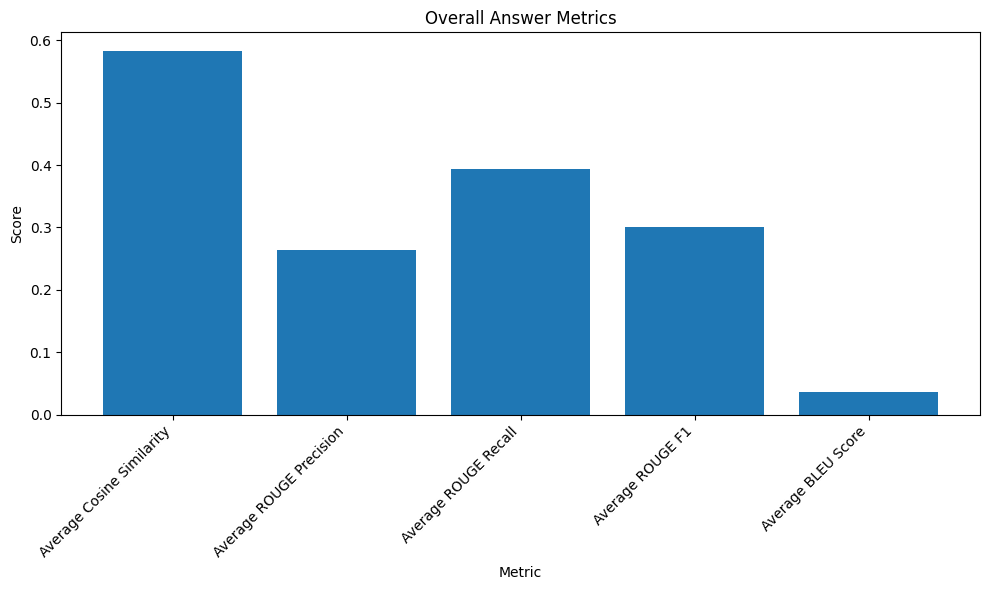

In [45]:
!pip install matplotlib -q

import matplotlib.pyplot as plt

# ... (rest of the code) ...

# Usage
evaluator = AnswerEvaluator(ground_truths, generated_answers)

# Evaluate answers
detailed_metrics, overall_metrics = evaluator.evaluate_answers()

# ... (Print results as before) ...

# Visualize overall metrics
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(list(overall_metrics.keys()), list(overall_metrics.values()))
plt.title('Overall Answer Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()